In [1]:
import pandas as pd
import numpy as np
#실제 그래프를 그릴 수 있는 서브 함수
import matplotlib.pyplot as plt
import seaborn as sns

#경고표시 생략(일시적으로 생략하는게 좋음) 
import warnings
warnings.filterwarnings(action='ignore')

#한글폰트 지정 
import matplotlib.font_manager as fm
font_name= fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font",family=font_name)

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False

## 서울시 구별 cctv 현황 분석


### 1.데이터 수집

+ http://data.seoul.go.kr/dataList/OA-2734/F/1/datasetView.do;jsessionid=CA8C8D843456102EC00DC9723EA0D560.new_portal-svr-21
    - CCTV 현황 
    
+ https://data.seoul.go.kr/dataList/419/S/2/datasetView.do
    - 서울시 인구

In [2]:
##### cctv 자료 

cctv_seoul = pd.read_csv('data/seoul/cctv.csv')
cctv_seoul.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [59]:
##### 인구자료 
# 엑셀파일에서 필요한 칼럼만 가져오기, 칼럼명이 3개? --> 1개만 가져오기 header=2
pop_seoul = pd.read_excel('data/seoul/Report.xls',usecols='B,D,G,J,N',header=2)
pop_seoul.head()

,자치구,계,계.1,계.2,65세이상고령자
0,합계,10112070,9838892,273178,1382420
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752


## 2. EDA & Preprocessing



##### 2-1. 컬럼이름 변경


In [21]:
##### CCTV 자료에서 '기관명' 이라는 칼럼을 '구별로 변경'
cctv_seoul.rename(columns = {"기관명":"구별"}, inplace=True)
# cctv_seoul.columns=['구별', '소계', '2013년도 이전', '2014년', '2015년', '2016년']
# cctv_seoul.rename(columns={cctv_seoul.columns[0]:"구별"},inplace =True)
cctv_seoul.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [60]:
##### 인구수 자료에서 컬럼명을 각각 구별, 인구수, 한국인, 외국인, 고령자로 변경
pop_seoul.columns=['구별','인구수', '한국인', '외국인', '고령자']
pop_seoul.head()

,구별,인구수,한국인,외국인,고령자
0,합계,10112070,9838892,273178,1382420
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752


#### 2-2. cctv 현황탐색
+ 어느 구가 가장 cctv가 많이 설치되어 있는가? 또는 가장 적게 설치되었는가? 

In [27]:
# 가장 많이
cctv_seoul.sort_values('소계',ascending=False)[['구별','소계']]
# cctv_seoul.sort_values('소계',ascending=False).head()

#가장 적게
cctv_seoul.sort_values('소계').head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
9,도봉구,825,238,159,42,386
2,강북구,831,369,120,138,204
5,광진구,878,573,78,53,174
3,강서구,911,388,258,184,81
24,중랑구,916,509,121,177,109


In [33]:
##### cctv의 설치 증가율에 따라 가장 높은 구와 가장 낮은 구를 탐색
##### cctv의 설치 연도별 증가율을 구해서 '최근증가율' 파생변수 추가 
##### ((2014+2015+2016)/2013년도 이전)*100
cctv_seoul['최근증가율']= (cctv_seoul['2014년']+cctv_seoul['2015년']+cctv_seoul['2016년'])/cctv_seoul['2013년도 이전']*100

#최근 증가율이 가장 높은 구와 낮은구를 조회 
print(cctv_seoul.sort_values('최근증가율',ascending=False).head(1))
print(cctv_seoul.sort_values('최근증가율',ascending=True).head(1))

     구별    소계  2013년도 이전  2014년  2015년  2016년       최근증가율
22  종로구  1619        464    314    211    630  248.922414
     구별    소계  2013년도 이전  2014년  2015년  2016년      최근증가율
18  양천구  2482       1843    142     30    467  34.671731


##### 2-3. 인구수 탐색

+어느구가 가장 인구수가 많은가? 또는 적은가?

In [61]:
# 필요없는 행 삭제(서울시 전체 합계 삭제): 열지울때 편함del, 행지울때 편함drop)
# pop_seoul=pop_seoul.drop([0])
pop_seoul.drop([0],inplace=True)
pop_seoul

,구별,인구수,한국인,외국인,고령자
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752
5,광진구,371671,357149,14522,44470
6,동대문구,364962,349308,15654,56284
7,중랑구,411552,406868,4684,59992
8,성북구,453902,442226,11676,66896
9,강북구,327511,323862,3649,57002
10,도봉구,345041,342861,2180,54293


In [62]:
# 구별 데이터의 중복이나 결측치들을 확인 

print(len(pop_seoul['구별'].unique())) # 전체를 세줌 
print(pop_seoul['구별'].count()) # 결측치를 빼고 숫자 세줌
#--> 결측치가 존재함을 알 수 있음 
pop_seoul.isnull().sum() # 결측치 개수 

# 인덱싱을 해주면 결측지가 어떤건지 알려줌
pop_seoul[pop_seoul['구별'].isnull()]

26
25


,구별,인구수,한국인,외국인,고령자
26,NaN,0,0,0,0


In [63]:
##### 결측치 삭제 
pop_seoul.drop([26],inplace=True)
pop_seoul

,구별,인구수,한국인,외국인,고령자
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752
5,광진구,371671,357149,14522,44470
6,동대문구,364962,349308,15654,56284
7,중랑구,411552,406868,4684,59992
8,성북구,453902,442226,11676,66896
9,강북구,327511,323862,3649,57002
10,도봉구,345041,342861,2180,54293


In [66]:
#### 단순히 인수수만 탐색(전체,외국인, 고령자)

print(pop_seoul.sort_values(by='인구수',ascending=True).head())
print('-----------------------------------------------------------')
print(pop_seoul.sort_values(by='인구수',ascending=False).head())
print('===========================================================')
print(pop_seoul.sort_values(by='외국인',ascending=True).head())
print('-----------------------------------------------------------')
print(pop_seoul.sort_values(by='외국인',ascending=False).head())
print('===========================================================')
print(pop_seoul.sort_values(by='고령자',ascending=True).head())
print('-----------------------------------------------------------')
print(pop_seoul.sort_values(by='고령자',ascending=False).head())

     구별     인구수     한국인    외국인    고령자
2    중구  135139  126082   9057  21655
1   종로구  164348  154549   9799  26429
3   용산구  245411  229909  15502  37238
18  금천구  253344  234238  19106  34640
4   성동구  314551  306532   8019  41752
-----------------------------------------------------------
     구별     인구수     한국인    외국인    고령자
24  송파구  671994  665282   6712  77978
16  강서구  608361  601696   6665  77381
23  강남구  557865  552976   4889  65859
11  노원구  555803  551902   3901  75081
21  관악구  522292  504445  17847  70807
     구별     인구수     한국인   외국인    고령자
10  도봉구  345041  342861  2180  54293
9   강북구  327511  323862  3649  57002
15  양천구  473087  469221  3866  56070
11  노원구  555803  551902  3901  75081
25  강동구  438225  434027  4198  56983
-----------------------------------------------------------
      구별     인구수     한국인    외국인    고령자
19  영등포구  403988  369128  34860  54704
17   구로구  440396  408369  32027  59838
18   금천구  253344  234238  19106  34640
21   관악구  522292  504445  17847  70807
6   동대문

In [67]:
##### 전체 인구 대비 외국인비율, 고령자비율 파생변수를 추가해서 순위 확인

pop_seoul['외국인비율'] = pop_seoul['외국인']/pop_seoul['인구수']*100
pop_seoul['고령자비율'] = pop_seoul['고령자']/pop_seoul['인구수']*100

In [72]:
print(pop_seoul.sort_values(by=['외국인비율'],ascending=True).head())
print(pop_seoul.sort_values(by=['외국인비율'],ascending=False).head())

     구별     인구수     한국인   외국인    고령자     외국인비율      고령자비율
10  도봉구  345041  342861  2180  54293  0.631809  15.735231
11  노원구  555803  551902  3901  75081  0.701867  13.508563
15  양천구  473087  469221  3866  56070  0.817186  11.851943
23  강남구  557865  552976  4889  65859  0.876377  11.805544
12  은평구  490253  485902  4351  75535  0.887501  15.407351
      구별     인구수     한국인    외국인    고령자     외국인비율      고령자비율
19  영등포구  403988  369128  34860  54704  8.628969  13.540996
18   금천구  253344  234238  19106  34640  7.541525  13.673109
17   구로구  440396  408369  32027  59838  7.272319  13.587317
2     중구  135139  126082   9057  21655  6.701988  16.024242
3    용산구  245411  229909  15502  37238  6.316750  15.173729


In [73]:
print(pop_seoul.sort_values(by=['고령자비율'],ascending=True).head())
print(pop_seoul.sort_values(by=['고령자비율'],ascending=False).head())

     구별     인구수     한국인    외국인    고령자     외국인비율      고령자비율
24  송파구  671994  665282   6712  77978  0.998818  11.603973
23  강남구  557865  552976   4889  65859  0.876377  11.805544
15  양천구  473087  469221   3866  56070  0.817186  11.851943
5   광진구  371671  357149  14522  44470  3.907219  11.964883
22  서초구  445164  440954   4210  54055  0.945719  12.142716
      구별     인구수     한국인    외국인    고령자     외국인비율      고령자비율
9    강북구  327511  323862   3649  57002  1.114161  17.404606
1    종로구  164348  154549   9799  26429  5.962348  16.081121
2     중구  135139  126082   9057  21655  6.701988  16.024242
10   도봉구  345041  342861   2180  54293  0.631809  15.735231
6   동대문구  364962  349308  15654  56284  4.289214  15.421880


#### 2-4. 인구대비 cctv 설치현황

In [74]:
##### cctv 데이터와 인구수 데이터를 합치기 

data_result=pd.merge(cctv_seoul,pop_seoul,on='구별')
data_result.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,1292,430,584,932,150.619195,557865,552976,4889,65859,0.876377,11.805544
1,강동구,1010,379,99,155,377,166.490765,438225,434027,4198,56983,0.957955,13.003138
2,강북구,831,369,120,138,204,125.203252,327511,323862,3649,57002,1.114161,17.404606
3,강서구,911,388,258,184,81,134.793814,608361,601696,6665,77381,1.095567,12.719586
4,관악구,2109,846,260,390,613,149.290780,522292,504445,17847,70807,3.417054,13.556976


In [75]:
##### 필요없는 칼럼 삭제
del data_result['2013년도 이전']
del data_result['2014년']
del data_result['2015년']
del data_result['2016년']

In [76]:
data_result.head()

,구별,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544
1,강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138
2,강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606
3,강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586
4,관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976


In [81]:
##### 구별이 기준이니까 구별을 인덱스로 두기
data_result.set_index('구별',inplace=True)


KeyError: "None of ['구별'] are in the columns"

In [82]:
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976


In [83]:
##### cctv 갯수와 인구데이터 중 어느 변수가 관계가 있는지를 확인해보자 
data_result.corr()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
소계,1.000000,-0.264378,0.230372,0.225689,0.027741,0.163106,-0.046570,-0.267835
최근증가율,-0.264378,1.000000,-0.097766,-0.086856,-0.150683,-0.072493,-0.043434,0.193834
인구수,0.230372,-0.097766,1.000000,0.997991,-0.164788,0.938610,-0.593687,-0.626751
한국인,0.225689,-0.086856,0.997991,1.000000,-0.226943,0.937972,-0.640342,-0.617241
외국인,0.027741,-0.150683,-0.164788,-0.226943,1.000000,-0.174105,0.842769,-0.025187
고령자,0.163106,-0.072493,0.938610,0.937972,-0.174105,1.000000,-0.613892,-0.340203
외국인비율,-0.046570,-0.043434,-0.593687,-0.640342,0.842769,-0.613892,1.000000,0.229849
고령자비율,-0.267835,0.193834,-0.626751,-0.617241,-0.025187,-0.340203,0.229849,1.000000


In [85]:
print(np.corrcoef(data_result['고령자비율'],data_result['소계']))
print(np.corrcoef(data_result['외국인비율'],data_result['소계']))
print(np.corrcoef(data_result['인구수'],data_result['소계']))

# 원하는 방향이 양의 관계이기 때문에 인구수가 가장 관계가 있다 볼 수 있음. 그러나 이정도의 상관은 거의 없는것.
#사실 노령자비율이 가장 상관관계가 높음. 

[[ 1.         -0.26783452]
 [-0.26783452  1.        ]]
[[ 1.         -0.04656978]
 [-0.04656978  1.        ]]
[[1.         0.23037183]
 [0.23037183 1.        ]]


In [86]:
##### 중간체크포인트 
data_result.to_csv('data/seoul/cctv_result.csv',sep=',',encoding='utf-8')

In [89]:
##### 파일 불러오기
data_result = pd.read_csv('data/seoul/cctv_result.csv')
data_result
#--> 인덱스는 풀림 따라서 index_col='구별'로 해주면 됨 
data_result = pd.read_csv('data/seoul/cctv_result.csv',index_col='구별')
data_result

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976
광진구,878,53.228621,371671,357149,14522,44470,3.907219,11.964883
구로구,1884,64.973730,440396,408369,32027,59838,7.272319,13.587317
금천구,1348,100.000000,253344,234238,19106,34640,7.541525,13.673109
노원구,1566,188.929889,555803,551902,3901,75081,0.701867,13.508563


### 3. visualization 

#### 3-1. cctv가 많이 설치된 구 확인

<AxesSubplot:xlabel='구별'>

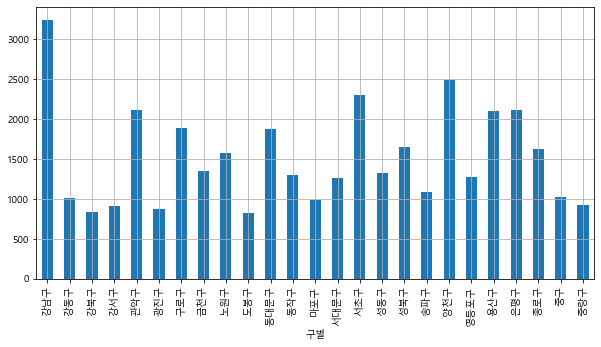

In [92]:
data_result['소계'].plot(kind='bar')
data_result['소계'].plot.bar()

data_result['소계'].plot(kind='bar',figsize=(10,5),grid=True)

<AxesSubplot:ylabel='구별'>

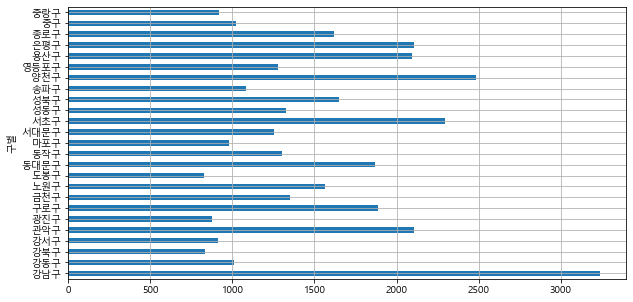

In [95]:
data_result['소계'].plot(kind='barh',figsize=(10,5),grid=True)

<AxesSubplot:ylabel='구별'>

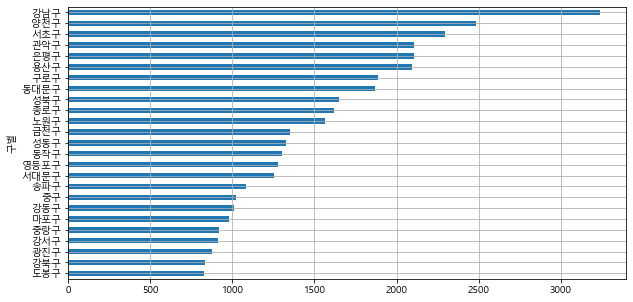

In [96]:
# 그래프가 이쁘게 정렬을 해보자
data_result['소계'].sort_values().plot(kind='barh',figsize=(10,5),grid=True)

#--> 이것은 결론이 아님 

#### 3-1. 인구 대비 cctv 개수 확인 

In [99]:
##### cctv 비율 파생변수 추가 (소계/인구수)*100 --> 인구대비 cctv수 

data_result['CCTV 비율'] = data_result['소계']/data_result['인구수']*100
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV 비율
구별,,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544,0.580427
강동구,1010,166.490765,438225,434027,4198,56983,0.957955,13.003138,0.230475
강북구,831,125.203252,327511,323862,3649,57002,1.114161,17.404606,0.253732
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586,0.149747
관악구,2109,149.290780,522292,504445,17847,70807,3.417054,13.556976,0.403797


<AxesSubplot:ylabel='구별'>

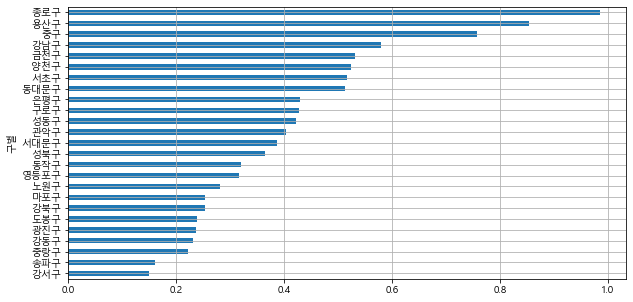

In [100]:
data_result['CCTV 비율'].sort_values().plot(kind='barh',figsize=(10,5),grid=True)

### 결론!! 
# 종로구가 인구수 대비 cctv가 제일 많음 
#종로, 용산, 중구, 강남

#가장 적은 동네는
#강서, 송파, 중랑, 강동

#나머지는 시각화의 문제 좀더 꾸미고 싶다면 단순한 막대 그래프가 아닌 다른 그래프를 사용해도됨. 

In [ ]:
# 단순히 많고 적고가 아닌 어느정도 설치가 적당한지등과 같은 

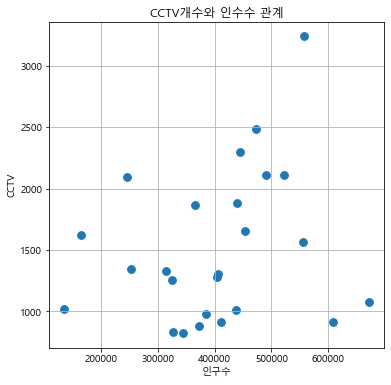

In [143]:
##### cctv개수와 인구수가 서로 관계가 있는지 산포도로 확인 
plt.figure(figsize=(6,6))
plt.scatter('인구수','소계',data=data_result,s=60) # s=60 은 점의 크기 
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.title('CCTV개수와 인수수 관계')
plt.grid()

<AxesSubplot:xlabel='인구수', ylabel='소계'>

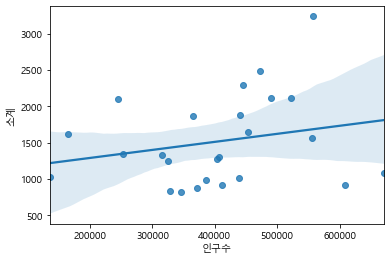

In [104]:
sns.regplot(x='인구수',y='소계',data=data_result)
# 이걸 찾아 주면 되는데 --> 그래프를 꾸밀 수 없음. 

[1.10432363e-03 1.06864009e+03]
 
0.001104 x + 1069


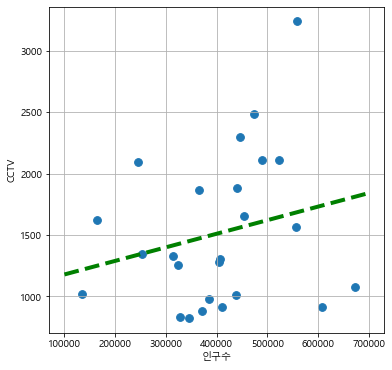

In [148]:
##### 회귀선 작성(y=wx + b)
#기울기와 절편을 찾아주는 함수 polyfit() --> 단순히 기울기랑 절편만 구해줌
# rm은 통계적 분석까지 
fp1=np.polyfit(data_result['인구수'],data_result['소계'],1)
print(fp1)

#방정식으로 만들어주는 함수가 또 있음
f1=np.poly1d(fp1)
print(f1)

# x축의 범위 준비
fx=np.linspace(100000,700000,100)

plt.figure(figsize=(6,6))
plt.scatter('인구수','소계',data=data_result,s=60) # s=60 은 점의 크기 
plt.plot(fx,f1(fx),lw=4,color='g',ls='dashed') # 회귀선 모양 꾸미기
# plt.plot(fx,fp1[0]*fx+fp1[1])
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()

In [136]:
# 이상치들이 어디인지 알아야할꺼아냐??
# 일단 오차를 알아야함. 

##### 각 데이터의 오차를 구해서 '오차'라는 파생변수를 추가 

data_result['오차']=np.abs(data_result['소계']-f1(data_result['인구수'])) # --> 절대값으로 해야함.
df_sort=data_result.sort_values(by='오차',ascending=False)
df_sort

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV 비율,오차
구별,,,,,,,,,,
강남구,3238,150.619195,557865,552976,4889,65859,0.876377,11.805544,0.580427,1553.296412
양천구,2482,34.671731,473087,469221,3866,56070,0.817186,11.851943,0.524639,890.918761
강서구,911,134.793814,608361,601696,6665,77381,1.095567,12.719586,0.149747,829.467513
용산구,2096,53.216374,245411,229909,15502,37238,6.316750,15.173729,0.854077,756.346747
서초구,2297,63.371266,445164,440954,4210,54055,0.945719,12.142716,0.515990,736.754790
송파구,1081,104.347826,671994,665282,6712,77978,0.998818,11.603973,0.160865,729.738939
도봉구,825,246.638655,345041,342861,2180,54293,0.631809,15.735231,0.239102,624.677016
중랑구,916,79.960707,411552,406868,4684,59992,1.138131,14.577016,0.222572,607.126685
광진구,878,53.228621,371671,357149,14522,44470,3.907219,11.964883,0.236230,601.085154


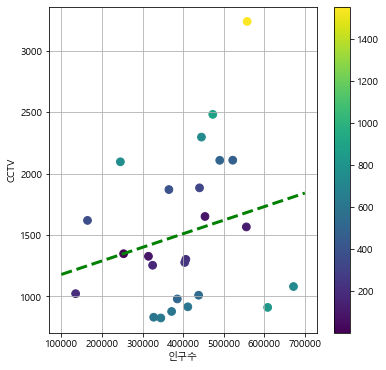

In [137]:
plt.figure(figsize=(6,6))
plt.scatter('인구수','소계',data=data_result,s=60,c=data_result['오차']) #오차의 색상구분  
plt.plot(fx,f1(fx),lw=3,color='g',ls='dashed') # 회귀선 모양 꾸미기

plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.colorbar() # 오차 범례 지정 
plt.grid()

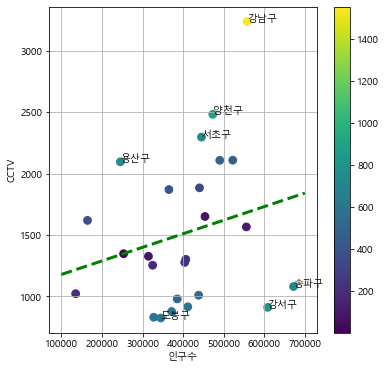

In [141]:
#결측치가 무엇인지 알아봐야지 
plt.figure(figsize=(6,6))
plt.scatter('인구수','소계',data=data_result,s=60,c=data_result['오차'])
plt.plot(fx,f1(fx),lw=3,color='g',ls='dashed') 

plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.colorbar() # 오차 범례 지정 
plt.grid()

for n in range(7):
    plt.text(df_sort['인구수'][n],df_sort['소계'][n],
                                      df_sort.index[n],fontsize=10)

In [142]:
##### 최종결과
df_sort.to_csv('data/seoul/cctv_result.csv',sep=',',encoding='utf-8')